# Final Model

After completing all preliminary experiments and hyperparameter tuning, we proceed to train our final character-level language model using the best-found hyperparameters. The following sections detail the training process, evaluation metrics, and visualizations of the model's performance. We ensure to save all relevant results, checkpoints and plots to local storage as well as to Google Drive for future reference and more importantly backup, just in case of any unforeseen runtime disconnections.

In [1]:
import matplotlib.pyplot as plt
import optax
import sys
import jax
import time
import os
import numpy as np

import setup_utils as su_utils
import training_utils as tr_utils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set up a backup drive and download directory
DRIVE_BACKUP_DIR = "/content/drive/MyDrive/final_model_results"
os.makedirs(DRIVE_BACKUP_DIR, exist_ok=True)

Mounted at /content/drive


# Load the Experiment Setup

## Set the relevant directory paths & log files

Here, we set the necessary directories and output paths for saving model checkpoints and log results.

In [3]:
# Input name of train & test files
train_file = "./text8_train.txt"
test_file = "./text8_test.txt"

# Input name of config and log files
config_file = "./config.json"
training_log_file = "./training_results.log"
validation_log_file = "./validation_results.log"
test_log_file = "./test_results.log"
checkpoint_file = "./checkpoint.pkl"

In [4]:
# Set up directories and log files
su_utils.setup(training_log_file, validation_log_file, test_log_file)

[initialize_training_log] Initialized training log file at ./training_results.log
[initialize_validation_log] Initialized validation log file at ./validation_results.log
[initialize_test_log] Initialized test log file at ./test_results.log


## Load the experiment configurations

Prior to running this notebook, the experiment configurations will be set in a 'config.json' file, which will be loaded to set the model hyperparameters and training settings.

In [5]:
name, description, seed, model, training, throughput = su_utils.load_config("./config.json")

print(f"We will be {description}")

[load_config] Loaded configuration from ./config.json
We will be Training the final character-level LLM with chosen architecture and hyperparameters.


In [7]:
# Set up Model Configurations
vocab_size, d_model, n_heads = model['vocab_size'], model['d_model'], model['n_heads']
n_layers, mlp_ratio, seq_len = model['n_layers'], model['mlp_ratio'], model['seq_len']

dropout, pos_encoding, attention_type = model['dropout'], model['pos_encoding'], model['attention_type']
use_auxiliary_loss, aux_heads, aux_weight = model['use_auxiliary_loss'], model['aux_heads'], model['aux_weight']
loss_type, mixed_precision = model['loss_type'], model['mixed_precision']

print(
    f"Model configurations set: \n"
    f"d_model={d_model}, n_heads={n_heads}, n_layers={n_layers}, seq_len={seq_len}\n"
    f"n_layers={n_layers}, mlp_ratio={mlp_ratio}, dropout={dropout}\n"
)

# Set up Training Configurations
val_fraction, batch_size = training['val_fraction'], training['batch_size']
learning_rate, weight_decay, lr_schedule = training['learning_rate'], training['weight_decay'], training['lr_schedule']
optimizer_type, warmup_ratio, label_smoothing, grad_clip = training['optimizer'], training['warmup_ratio'], float(training['label_smoothing']), training['grad_clip']

print(
    f"Training configurations set: \n"
    f"batch_size={batch_size}, learning_rate={learning_rate}, weight_decay={weight_decay}\n"
    f"optimizer={optimizer_type}, lr_schedule={lr_schedule}, warmup_ratio={warmup_ratio}\n"
)

# Set up Throughput Configurations
max_test_iters, max_test_time = throughput['max_test_iters'], throughput['max_test_time_in_seconds']
compute_budget_hours = throughput['compute_budget_hours']

print(
    f"Throughput configurations set: \n"
    f"max_test_iters={max_test_iters}iters, max_test_time={max_test_time}s, compute_budget_hours={compute_budget_hours}H ({compute_budget_hours*3600:.2f}s)\n"
)

Model configurations set: 
d_model=256, n_heads=4, n_layers=6, seq_len=128
n_layers=6, mlp_ratio=4, dropout=0.0

Training configurations set: 
batch_size=32, learning_rate=0.001, weight_decay=0.0
optimizer=adam, lr_schedule=constant, warmup_ratio=none

Throughput configurations set: 
max_test_iters=2000iters, max_test_time=60s, compute_budget_hours=0.833H (2998.80s)



# Loading the Data

The text8 dataset is used, which has 100M characters of text data from Wikipedia articles. It contains only lowercase letters and spaces, and is already pre-split into 90M characters for training and 10M characters for testing.

In [8]:
train_text, test_text, chars_to_int, int_to_chars = su_utils.load_dataset(train_file, test_file)

[load_dataset] Loaded training text from ./text8_train.txt. Length: 90,000,000 characters.

[load_dataset] Loaded testing text from ./text8_test.txt. Length: 5,000,000 characters.

[load_dataset] First 100 characters of training text:
 anarchism originated as a term of abuse first used against early working class radicals including t

[load_dataset] First 100 characters of testing text:
be ejected and hold it there examine the chamber to ensure it is clear allow the action to go forwar

[load_dataset] Created character mappings. Vocabulary size: 27


We further split the training data into a training set and a validation set to monitor the model's performance during training, in accordance to the validation fraction specified in our configuration file (10%)

In [9]:
train_text, val_text = su_utils.split_train_val(train_text, val_fraction=val_fraction)

[split_train_val] Training text length: 89,099,996 characters.
[split_train_val] Validation text length: 900,004 characters.


We then encode the text data into integer format for model training. Each unique character is mapped to a unique integer index.

In [ ]:
# Encode the train, val, test texts
train_data = tr_utils.encode(train_text, chars_to_int)
val_data = tr_utils.encode(val_text, chars_to_int)
test_data = tr_utils.encode(test_text, chars_to_int)

# Model Initialisation

## Model Setup

We intialise our model with the following parameters in accordance to our configuration file.
Based on these parameters, our model has approximately ~4.2M parameters.

In [10]:
# Define the model params
rng = jax.random.PRNGKey(seed)

model_obj, params, constants = tr_utils.create_train_state(
        rng,
        vocab_size = vocab_size,
        d_model = d_model,
        n_heads = n_heads,
        n_layers = n_layers,
        mlp_ratio = mlp_ratio,
        seq_len = seq_len,
        dropout = dropout,
        aux_loss = use_auxiliary_loss,
        num_aux_heads = aux_heads,
        mixed_precision = mixed_precision,
        attention_type = attention_type,
        pos_encoding = pos_encoding
)

[create_train_state] Model initialized with 4,160,768 parameters.


We perform a sanity check by running a single forward pass with random input data to ensure the model is functioning as expected.

In [11]:
# SANITY CHECK: Test the model forward pass
B, T = 2, 8  # Batch size and sequence length
batch = jax.random.randint(key = rng, shape = (B, T), minval = 0, maxval = vocab_size)

variables = {"params": params, "constants": constants}
output = model_obj.apply(variables, batch, deterministic=False, rngs={"dropout": rng})

print("Logits shape:", output["logits"].shape)  # Expected: (B, T, vocab_size)

if output["logits"].shape[0] == B and output["logits"].shape[1] == T and output["logits"].shape[2] == vocab_size:
    print("Sanity check passed: Model forward pass output shape is correct.")
else:
    print("Sanity check failed: Model forward pass output shape is incorrect.")


Logits shape: (2, 8, 27)
Sanity check passed: Model forward pass output shape is correct.


## Determine maximum permissible training steps

Taking into account possible compute limitations, we perform a preliminary calculation to determine the maximum number of training steps we can perform based on the throughput of our model and the total training time available. For this preliminary test, the default maximum training time is 60 seconds, and commpute budget hours is 5 hours.

Based on the throughput calculated from the preliminary test, the estimated maximum no. of training steps we can perform within this compute budget is ~___,000. To ensure we keep within the budget, we set the maximum training steps to be ___,000.

In [ ]:
# Create a dummy optimizer and opt_state for throughput calculation
dummy_optimizer, dummy_opt_state = tr_utils.create_dummy_optimizer(
    learning_rate = learning_rate,
    optimizer_type = optimizer_type,
    weight_decay = weight_decay,
    params = params
)

# Determining how many steps we can run in a reasonable time
_ , max_steps = tr_utils.calculate_throughput(
    max_test_iters = max_test_iters,
    max_test_time = max_test_time,
    model = model_obj,
    params = params,
    opt_state = dummy_opt_state,
    optimizer = dummy_optimizer,
    rng = rng,
    batch_size = batch_size,
    seq_len = seq_len,
    compute_budget = compute_budget_hours,
    train_data = train_data,
    loss_type = loss_type,
    aux_loss = use_auxiliary_loss,
    aux_weight = aux_weight,
    constants = constants,
    label_smoothing = label_smoothing
)

Stopping benchmark at iteration 1203 due to time limit.
Benchmark completed in 60.04 seconds.
Total tokens processed: 4931584
Throughput: 82142.36 tokens/second
Estimated max steps within compute budget: 60138.0


## Initialise the optimizer

In this section, we set up the optimizer for training our model in accordance to our configuration file.

In [ ]:
iter_max = 100 # Set max iterations in accordance to compute budget
# iter_max = int(max_steps * 0.9)  # If we want to use 90% of the computed max steps
print(f"Setting iter_max = {iter_max}.\n")

optimizer, opt_state = tr_utils.initialize_optimizer(
    params=params,
    iter_max=iter_max,
    optimizer_type=optimizer_type,
    lr_schedule=lr_schedule,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    grad_clip=grad_clip
)

Setting iter_max = 100.
[initialize_optimizer] Initialized adam optimizer configurations:learning_rate_schedule=constant, learning_rate=0.001, weight_decay=0.0, grad_clip=noneweight_decay applied: no, grad_clip applied: nowarmup_ratio=none, total_iterations=100


# Model Training & Evaluation

## Training the model

Now, we proceed to train the model over the determined number of training iterations. During training, we monitor the training loss and periodically evaluate the model on the validation set to track its performance. We also make sure to record the time taken for training to ensure it stays within our compute budget.

In [15]:
log_val_every = max(1, iter_max // 100) # Determine Validation logging frequency
save_checkpoint_every = max(1, iter_max // 20) # Determine Checkpoint saving frequency
upload_to_drive_every = max(1, iter_max // 20) # Determine Drive upload frequency
num_val_batches = 5  # Number of validation batches to average over

# To track training and validation loss, as well as time taken
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
last_char_train_acc_history = []
last_char_val_acc_history = []
train_step_history = list(range(iter_max))
val_step_history = []

# Load checkpoint if it exists
params, opt_state, constants, start_iter = su_utils.load_checkpoint(
    checkpoint_file,
    params,
    constants,
    opt_state
)

[load_checkpoint] No checkpoint found at ./checkpoint.pkl
[load_checkpoint] Starting training as per normal.


We then train the model and log the training and validation losses for analysis. All relevant results, checkpoints and plots are saved periodically to local storage as well as to Google Drive for future reference and backup.

In [16]:
if start_iter > 0:
        print(f"Resuming training from iteration = {start_iter}.")
else:
        print("Starting training from iteration = 0.")

time_start = time.time()
best_val_loss = float('inf')

for it in range(start_iter, iter_max):

    # get a batch of data
    inputs, targets = tr_utils.get_batch(train_data, batch_size, seq_len)

    # Perform a training step
    rng, sub = jax.random.split(rng)
    new_params, new_opt_state, metrics = tr_utils.train_step(
            model = model_obj,
            params = params,
            constants=constants,
            opt_state = opt_state,
            x = inputs,
            y = targets,
            tx = optimizer,
            rng = sub,
            loss_type = loss_type,
            aux_loss = use_auxiliary_loss,
            aux_weight = aux_weight,
            label_smoothing = label_smoothing
    )

    # Update parameters and optimizer state
    params = new_params
    opt_state = new_opt_state

    # Record training metrics
    acc = metrics['acc']
    loss = metrics['loss']
    last_char_acc = metrics['acc_last']
    train_time = time.time() - time_start

    train_loss_history.append(loss)
    train_acc_history.append(acc)
    last_char_train_acc_history.append(last_char_acc)

    su_utils.update_training_log(
        log_path = "training_results.log",
        step = it,
        train_loss = loss,
        train_time = train_time,
        train_acc = acc,
        last_char_acc = last_char_acc
        )

    # Upload training log to Drive at regular intervals
    if (it % upload_to_drive_every) == 0 or (it == iter_max - 1):
        su_utils.save_to_drive(
            drive_backup_dir=DRIVE_BACKUP_DIR,
            file_name="training_results.log"
        )

    # Perform validation and checkpoint saving at specified intervals
    if (it % log_val_every) == 0 or (it == iter_max - 1): # Print every 1% of iterations

        val_losses = []
        val_accs = []
        val_last_char_accs = []

        for _ in range(num_val_batches):
            # Compute the loss on validation set
            batch_size_val = batch_size
            seq_len_val = seq_len
            val_inputs, val_targets = tr_utils.get_batch(val_data, batch_size_val, seq_len_val)

            val_out = model_obj.apply({"params": params, "constants": constants}, val_inputs, deterministic=True, rngs={"dropout": rng})
            val_logits = val_out["logits"]
            val_aux_logits = val_out.get('aux_logits', None)

            val_loss, val_metrics = tr_utils.loss_and_metrics(
                logits = val_logits,
                targets = val_targets,
                loss_type = loss_type,
                aux_loss = use_auxiliary_loss,
                aux_logits = val_aux_logits,
                aux_weight = aux_weight,
                label_smoothing = label_smoothing
            )

            # Record validation loss and time
            val_acc = val_metrics['acc']
            last_char_acc_val = val_metrics['acc_last']

            # Add validation metrics to lists
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_last_char_accs.append(last_char_acc_val)

        # Compute average validation metrics
        val_loss = np.mean(val_losses)
        val_acc = np.mean(val_accs)
        last_char_acc_val = np.mean(val_last_char_accs)

        # Record validation loss and time
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        last_char_val_acc_history.append(last_char_acc_val)
        time_elapsed = time.time() - time_start
        val_step_history.append(it)

        su_utils.update_validation_log(
            log_path = "validation_results.log",
            step = it,
            val_loss = val_loss,
            val_time = time_elapsed,
            val_acc = val_acc,
            last_char_val_acc = last_char_acc_val
        )

        # Upload validation log to Drive at regular intervals
        su_utils.save_to_drive(
            drive_backup_dir=DRIVE_BACKUP_DIR,
            file_name="validation_results.log"
        )

        # Save checkpoint at regular intervals
        if ((it % save_checkpoint_every) == 0 or (it == iter_max - 1)) and (val_loss - 0.005 < best_val_loss):

            # Save checkpoint in local directory
            su_utils.save_checkpoint(
                checkpoint_path = checkpoint_file,
                params = params,
                constants = constants,
                opt_state = opt_state,
                step = it,
                time_elapsed = time_elapsed
            )

            # Save checkpoint to Drive
            su_utils.save_to_drive(
                drive_backup_dir=DRIVE_BACKUP_DIR,
                file_name=checkpoint_file.split("/")[-1]
            )

            best_val_loss = val_loss

        # Print training and validation metrics
        print(f"Iteration {it}, time elapsed: {time_elapsed:.2f} seconds")
        print(f"\t \t Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"\t \t Training Acc: {acc:.4f}, Validation Acc: {val_acc:.4f}")
        print(f"\t \t Last Char Training Acc: {last_char_acc:.4f}, Last Char Validation Acc: {last_char_acc_val:.4f}")
        print("-" * 50)

print(f"Training completed in {time.time() - time_start:.2f} seconds.")

Starting training from iteration = 0.
[save_to_drive] Successfully saved training_results.log to /content/drive/MyDrive/final_model_results
[save_to_drive] Successfully saved validation_results.log to /content/drive/MyDrive/final_model_results
[save_checkpoint] Saved checkpoint at step 0 to ./checkpoint.pkl
[save_to_drive] Successfully saved checkpoint.pkl to /content/drive/MyDrive/final_model_results
Iteration 0, time elapsed: 20.03 seconds
	 	 Training Loss: 3.7071, Validation Loss: 4.4307
	 	 Training Acc: 0.0618, Validation Acc: 0.1657
	 	 Last Char Training Acc: 0.0312, Last Char Validation Acc: 0.1625
--------------------------------------------------
[save_to_drive] Successfully saved validation_results.log to /content/drive/MyDrive/final_model_results
Iteration 1, time elapsed: 23.77 seconds
	 	 Training Loss: 4.4141, Validation Loss: 4.2600
	 	 Training Acc: 0.1719, Validation Acc: 0.0924
	 	 Last Char Training Acc: 0.2500, Last Char Validation Acc: 0.1063
--------------------

## Testing the model on test data

Finally, we test the trained model on the test dataset over a set number of batches (`evaluation_batches`) to evaluate its performance. The test loss, accuracy and accuracy of the last character prediction are computed and reported.

In [17]:
# No. of batches to use for evaluation
evaluation_batches = 100

total_test_loss, total_test_acc, total_last_char_test_acc = tr_utils.evaluate_on_test_set(
    rng = rng,
    model = model_obj,
    params = params,
    constants = constants,
    test_data = test_data,
    batch_size = batch_size,
    seq_len = seq_len,
    loss_type = loss_type,
    aux_loss = use_auxiliary_loss,
    aux_weight = aux_weight,
    label_smoothing = label_smoothing,
    n_batches = evaluation_batches
)

for i in range(evaluation_batches):

    # Update test log
    su_utils.update_test_log(
        log_path = "./test_results.log",
        test_loss = total_test_loss[i],
        test_acc = total_test_acc[i],
        last_char_test_acc = total_last_char_test_acc[i]
    )

# Save test log to google drive
su_utils.save_to_drive(
    drive_backup_dir=DRIVE_BACKUP_DIR,
    file_name="test_results.log"
)

[evaluate_on_test_set] Metrics are averaged over 100 batches.
Mean Test Loss: 2.3232, Mean Test Accuracy: 0.3052, Mean Last Character Test Accuracy: 0.3041
Min Test Acc: 0.2781, Max Test Accuracy: 0.3364, Max Last Character Test Accuracy: 0.5312
Max Test Acc: 0.3364, Min Test Accuracy: 0.2781, Min Last Character Test Accuracy: 0.0938
S.D of Test Acc: 0.0102, S.D of Test Accuracy: 0.0102, S.D of Last Character Test Accuracy: 0.0765

[save_to_drive] Successfully saved test_results.log to /content/drive/MyDrive/final_model_results


## Plot the loss and accuracy curves

After training, we plot the training and validation loss curves to visualize the model's learning progress over time. This plot is saved to the specified output directory, and will be useful to observe trends such as overfitting or underfitting.

We also plot the training and validation accuracy curves to visualize the model's performance over time. This plot is saved to the specified output directory, and will help in assessing how well the model is learning to predict the next character in the sequence. We add in the mean test accuracy as well for comparison.

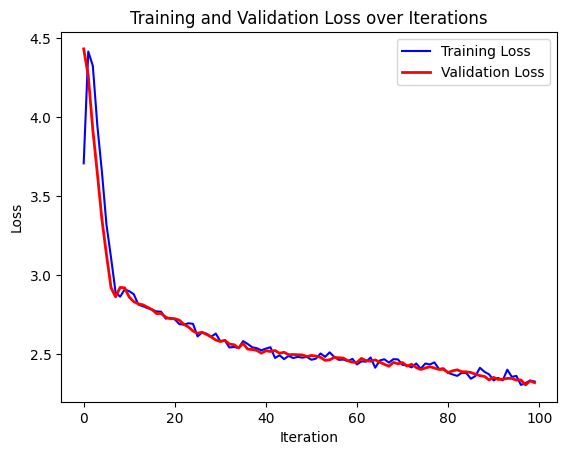

[save_to_drive] Successfully saved loss_curve.png to /content/drive/MyDrive/final_model_results


In [18]:
name_of_plot = "loss_curve"

# Plot training and validation loss curves
plt.plot(train_step_history, train_loss_history, "-",label='Training Loss', color='blue')
plt.plot(val_step_history, val_loss_history, "-", label='Validation Loss', lw = 2, color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss over Iterations")
plt.legend()
plt.savefig(f"./{name_of_plot}.png")
plt.show()

# Save plots to Drive
su_utils.save_to_drive(
    drive_backup_dir=DRIVE_BACKUP_DIR,
    file_name=f"{name_of_plot}.png"
)

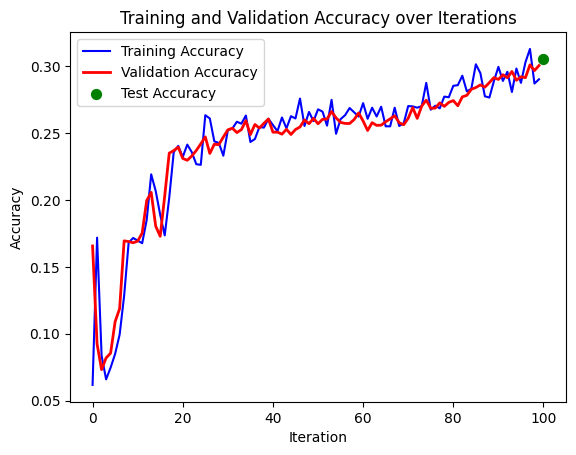

[save_to_drive] Successfully saved accuracy_curve.png to /content/drive/MyDrive/final_model_results


In [19]:
# Save plots to Drive
name_of_plot = "accuracy_curve"

# Plot training and validation loss curves
plt.plot(train_step_history, train_acc_history, "-",label='Training Accuracy', color='blue')
plt.plot(val_step_history, val_acc_history, "-", label='Validation Accuracy', lw = 2, color='red')
plt.scatter([iter_max], np.mean(total_test_acc), label='Test Accuracy', color='green', s = 50)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(loc = "upper right")
plt.title("Training and Validation Accuracy over Iterations")
plt.legend()
plt.savefig(f"./{name_of_plot}.png")
plt.show()

# Save plots to Drive
su_utils.save_to_drive(
    drive_backup_dir=DRIVE_BACKUP_DIR,
    file_name=f"{name_of_plot}.png"
)

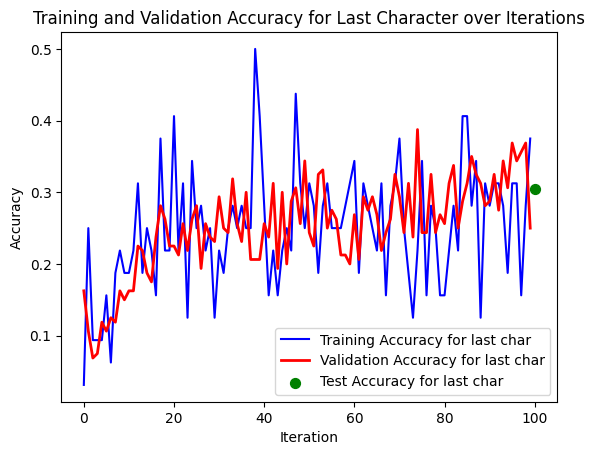

[save_to_drive] ERROR: [Errno 2] No such file or directory: 'accuracy_curve_last_char.png'


In [ ]:
name_of_plot = "last_char_accuracy_curve"

# Plot training and validation loss curves
plt.plot(train_step_history, last_char_train_acc_history, "-",label='Training Accuracy for last char', color='blue')
plt.plot(val_step_history, last_char_val_acc_history, "-", label='Validation Accuracy for last char', lw = 2, color='red')
plt.scatter([iter_max], np.mean(total_last_char_test_acc), label='Test Accuracy for last char', color='green', s = 50)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(loc = "upper right")
plt.title("Training and Validation Accuracy for Last Character over Iterations")
plt.legend()
plt.savefig(f"./{name_of_plot}.png")
plt.show()

# Save plots to Drive
su_utils.save_to_drive(
    drive_backup_dir=DRIVE_BACKUP_DIR,
    file_name=f"{name_of_plot}.png"
)

# Testing the model on a given prompt

We finally test the trained model by generating text based on a given prompt. The model successfully generates a sequence of characters that continue from the prompt, and we save the generated text to a file for review.

In [21]:
# Test the model on a given prompt
prompt = "the meaning of life is"
encoded_prompt = tr_utils.encode(prompt, chars_to_int)
context = encoded_prompt[None, :]

generate_len = 1000
rng = jax.random.PRNGKey(seed)

output_indices = tr_utils.generate_tokens(
    model=model_obj,
    params=params,
    constants=constants,
    rng=rng,
    context=context,
    length=generate_len,
    block_size=seq_len,
    temperature=0.8,
    sample=True,
    pad_id=None,
    deterministic=True
)

output_indices = np.array(output_indices)  # Convert from JAX array to NumPy array
generated_text = tr_utils.decode(output_indices, int_to_chars)

print("Generated ID Shape:", output_indices.shape)
print("Generated Text:")
print(prompt + generated_text)

generated_text_file = "./generated_text.txt"

with open(generated_text_file, "w") as f:
    f.write(prompt + generated_text)
    print(f"[Sample text generation] Generated text saved to {generated_text_file}.")

# Save generated text to Drive
su_utils.save_to_drive(
    drive_backup_dir=DRIVE_BACKUP_DIR,
    file_name="generated_text.txt"
)

Generated ID Shape: (1, 1000)
Generated Text:
the meaning of life isitolas roncl fiang alreneron intwlas geitidev irontinec dinsctsive icex acomoucees onthe thene hrote coun to ithas cost ongwewic thines win ca um neve caretig hof thitaced tof walirs tonatis nichid pr is war liop mat imat or eavarilf thug calinge no ceiles ceate whaly s tasstigon nthenth amus darsaditan fal a orke his aanco enive suis thid the bonic irorst or raila eror ta masimmd fithe al tor ronte ive bevof a cere fo ala fithrt the that thon the ins tontend thof toun isede cor dine tha thor jond ors fromem forr meronstetes lovianias ally weie tos of alomastsceven thronding mat terous and hisipatis eating heest erandely tim esiry decroce cor thald themter imisit e equs ixom woris one zinis ingles bye ace pitiluss tom wof mighe ating fisth thial thal allis and of cenie thernent this dontispoulin thand tine stro tho righy ans spearino nide heventhte rexe ncon iach he dike tof zerery lenone sthemd the thin seve o the and